In [1]:
"""
Please run notebook locally (if you have all the dependencies and a GPU). 
Technically you can run this notebook on Google Colab but you need to set up microphone for Colab.
 
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Set up microphone for Colab
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg portaudio19-dev
!pip install unidecode
!pip install pyaudio

# ## Install NeMo
!python -m pip install --upgrade git+https://github.com/NVIDIA/NeMo.git#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio>=0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Cloning https://github.com/NVIDIA/NeMo.git to /tmp/pip-install-6_y5c6kn/nemo-toolkit
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-6_y5c6kn/nemo-toolkit


  Created wheel for nemo-toolkit: filename=nemo_toolkit-1.0.0a3-py3-none-any.whl size=406837 sha256=a45dec67349e4fc2a7c10e68c9ad9888a128dcb24ffb5de219a8937244a8cf45
  Stored in directory: /tmp/pip-ephem-wheel-cache-_hda2uuo/wheels/ca/5b/0e/71899dca29347b09dbc4da53269775328537b8d86247e32e8c
Successfully built nemo-toolkit
  Attempting uninstall: nemo-toolkit
    Found existing installation: nemo-toolkit 1.0.0a3
    Uninstalling nemo-toolkit-1.0.0a3:
      Successfully uninstalled nemo-toolkit-1.0.0a3


This notebook demonstrates VAD (Voice Activity Detectoin) from a microphone's stream in NeMo.

It is **not a recommended** way to do inference in production workflows. If you are interested in 
production-level inference using NeMo ASR models, please sign-up to Jarvis early access program: https://developer.nvidia.com/nvidia-jarvis

The notebook requires PyAudio library to get a signal from an audio device.
For Ubuntu, please run the following commands to install it:
```
sudo apt-get install -y portaudio19-dev
pip install pyaudio
```

This notebook requires the `torchaudio` library to be installed for MatchboxNet. Please follow the instructions available at the [torchaudio Github page](https://github.com/pytorch/audio#installation) to install the appropriate version of torchaudio.

If you would like to install the latest version, please run the following command to install it:

```
conda install -c pytorch torchaudio
```

In [2]:
import numpy as np
import pyaudio as pa
import os, time
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

import nemo
import nemo.collections.asr as nemo_asr

[NeMo W 2020-09-22 14:57:06 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-09-22 14:57:06 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-09-22 14:57:06 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-09-22 14:57:06 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-09-22 14:57:06 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset'> is experimental,

In [3]:
# sample rate, Hz
SAMPLE_RATE = 16000

## Restore the model from NGC

In [4]:
asr_model = nemo_asr.models.EncDecClassificationModel.from_pretrained('MatchboxNet-VAD-3x2')

[NeMo I 2020-09-22 14:57:06 cloud:55] Found existing object /home/fjia/.cache/torch/NeMo/NeMo_1.0.0alpha3/MatchboxNet_VAD_3x2/28cab07c1cff9f1bb3f0c51b9838a4b3/MatchboxNet_VAD_3x2.nemo.
[NeMo I 2020-09-22 14:57:06 cloud:61] Re-using file from: /home/fjia/.cache/torch/NeMo/NeMo_1.0.0alpha3/MatchboxNet_VAD_3x2/28cab07c1cff9f1bb3f0c51b9838a4b3/MatchboxNet_VAD_3x2.nemo
[NeMo I 2020-09-22 14:57:06 common:394] Instantiating model from pre-trained checkpoint


[NeMo W 2020-09-22 14:57:07 modelPT:102] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /home/fjia/code/manifest64/balanced_background_training_manifest.json,/home/fjia/code/manifest64/balanced_speech_training_manifest.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 128
    num_workers: 20
    shuffle: true
    augmentor:
      shift:
        prob: 0.8
        min_shift_ms: -5.0
        max_shift_ms: 5.0
      white_noise:
        prob: 0.8
        min_level: -90
        max_level: -46
    
[NeMo W 2020-09-22 14:57:07 modelPT:109] Please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /home/fjia/code/manifest64/balanced_background_validation_manifest.json,/home/

[NeMo I 2020-09-22 14:57:08 modelPT:237] Model EncDecClassificationModel was successfully restored from /home/fjia/.cache/torch/NeMo/NeMo_1.0.0alpha3/MatchboxNet_VAD_3x2/28cab07c1cff9f1bb3f0c51b9838a4b3/MatchboxNet_VAD_3x2.nemo.


## Observing the config of the model

In [5]:
from omegaconf import OmegaConf
import copy

In [6]:
# Preserve a copy of the full config
cfg = copy.deepcopy(asr_model._cfg)
print(OmegaConf.to_yaml(cfg))

sample_rate: 16000
timesteps: 64
repeat: 2
dropout: 0.0
kernel_size_factor: 1.0
labels:
- background
- speech
train_ds:
  manifest_filepath: /home/fjia/code/manifest64/balanced_background_training_manifest.json,/home/fjia/code/manifest64/balanced_speech_training_manifest.json
  sample_rate: 16000
  labels:
  - background
  - speech
  batch_size: 128
  num_workers: 20
  shuffle: true
  augmentor:
    shift:
      prob: 0.8
      min_shift_ms: -5.0
      max_shift_ms: 5.0
    white_noise:
      prob: 0.8
      min_level: -90
      max_level: -46
validation_ds:
  manifest_filepath: /home/fjia/code/manifest64/balanced_background_validation_manifest.json,/home/fjia/code/manifest64/balanced_speech_validation_manifest.json
  sample_rate: 16000
  labels:
  - background
  - speech
  batch_size: 128
  shuffle: false
  val_loss_idx: 0
  num_workers: 20
test_ds:
  manifest_filepath: /home/fjia/code/manifest64/balanced_background_testing_manifest.json,/home/fjia/code/manifest64/balanced_speech_test

## Setup preprocessor with these settings

In [7]:
asr_model.preprocessor = asr_model.from_config_dict(cfg.preprocessor)

In [8]:
# Set model to inference mode
asr_model.eval();

In [9]:
asr_model = asr_model.to(asr_model.device)

## Setting up data for Streaming Inference

In [10]:
from nemo.core.classes import IterableDataset
from nemo.core.neural_types import NeuralType, AudioSignal, LengthsType
import torch
from torch.utils.data import DataLoader

In [11]:
# simple data layer to pass audio signal
class AudioDataLayer(IterableDataset):
    @property
    def output_types(self):
        return {
            'audio_signal': NeuralType(('B', 'T'), AudioSignal(freq=self._sample_rate)),
            'a_sig_length': NeuralType(tuple('B'), LengthsType()),
        }

    def __init__(self, sample_rate):
        super().__init__()
        self._sample_rate = sample_rate
        self.output = True
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if not self.output:
            raise StopIteration
        self.output = False
        return torch.as_tensor(self.signal, dtype=torch.float32), \
               torch.as_tensor(self.signal_shape, dtype=torch.int64)
        
    def set_signal(self, signal):
        self.signal = signal.astype(np.float32)/32768.
        self.signal_shape = self.signal.size
        self.output = True

    def __len__(self):
        return 1

In [12]:
data_layer = AudioDataLayer(sample_rate=cfg.train_ds.sample_rate)
data_loader = DataLoader(data_layer, batch_size=1, collate_fn=data_layer.collate_fn)

In [13]:
# inference method for audio signal (single instance)
def infer_signal(model, signal):
    data_layer.set_signal(signal)
    batch = next(iter(data_loader))
    audio_signal, audio_signal_len = batch
    audio_signal, audio_signal_len = audio_signal.to(asr_model.device), audio_signal_len.to(asr_model.device)
    logits = model.forward(input_signal=audio_signal, input_signal_length=audio_signal_len)
    return logits

In [14]:
# class for streaming frame-based VAD
# 1) use reset() method to reset FrameASR's state
# 2) call transcribe(frame) to do VAD on
#    contiguous signal's frames
class FrameASR:
    
    def __init__(self, model_definition,
                 frame_len=2, frame_overlap=2.5, 
                 offset=10):
        '''
        Args:
          frame_len: frame's duration, seconds
          frame_overlap: duration of overlaps before and after current frame, seconds
          offset: number of symbols to drop for smooth streaming
        '''
        self.vocab = list(model_definition['labels'])
        self.vocab.append('_')
        
        self.sr = model_definition['sample_rate']
        self.frame_len = frame_len
        self.n_frame_len = int(frame_len * self.sr)
        self.frame_overlap = frame_overlap
        self.n_frame_overlap = int(frame_overlap * self.sr)
        timestep_duration = model_definition['AudioToMFCCPreprocessor']['window_stride']
        for block in model_definition['JasperEncoder']['jasper']:
            timestep_duration *= block['stride'][0] ** block['repeat']
        self.buffer = np.zeros(shape=2*self.n_frame_overlap + self.n_frame_len,
                               dtype=np.float32)
        self.offset = offset
        self.reset()
        
    def _decode(self, frame, offset=0):
        assert len(frame)==self.n_frame_len
        self.buffer[:-self.n_frame_len] = self.buffer[self.n_frame_len:]
        self.buffer[-self.n_frame_len:] = frame
        logits = infer_signal(asr_model, self.buffer).cpu().numpy()[0]
        decoded = self._greedy_decoder(
            logits,
            self.vocab
        )
        return decoded  
    
    
    @torch.no_grad()
    def transcribe(self, frame=None):
        if frame is None:
            frame = np.zeros(shape=self.n_frame_len, dtype=np.float32)
        if len(frame) < self.n_frame_len:
            frame = np.pad(frame, [0, self.n_frame_len - len(frame)], 'constant')
        unmerged = self._decode(frame, self.offset)
        return unmerged
    
    def reset(self):
        '''
        Reset frame_history and decoder's state
        '''
        self.buffer=np.zeros(shape=self.buffer.shape, dtype=np.float32)
        self.prev_char = ''

    @staticmethod
    def _greedy_decoder(logits, vocab):
        s = []
        if logits.shape[0]:
            probs = torch.softmax(torch.as_tensor(logits), dim=-1)
            probas, preds = torch.max(probs, dim=-1)
            s = [preds.item(), str(vocab[preds]), probs[0].item(), probs[1].item(), str(logits)]
        return s

# Streaming Inference

Streaming inference depends on a few factors, such as the frame length (STEP) and buffer size (WINDOW SIZE). Experiment with a few values to see their effects in the below cells.

## offline inference

In [15]:
STEP_LIST =        [0.01,0.01,]
WINDOW_SIZE_LIST = [0.31,0.15,]

In [16]:
import wave

def offline_inference(wave_file, STEP = 0.025, WINDOW_SIZE = 0.5):
    
    FRAME_LEN = STEP # infer every STEP seconds 
    CHANNELS = 1 # number of audio channels (expect mono signal)
    RATE = 16000 # sample rate, Hz
    
   
    CHUNK_SIZE = int(FRAME_LEN*RATE)
    
    asr = FrameASR(model_definition = {
                   'sample_rate': SAMPLE_RATE,
                   'AudioToMFCCPreprocessor': cfg.preprocessor.params,
                   'JasperEncoder': cfg.encoder.params,
                   'labels': cfg.labels
               },
               frame_len=FRAME_LEN, frame_overlap = (WINDOW_SIZE-FRAME_LEN)/2,
               offset=0)

    wf = wave.open(wave_file, 'rb')
    p = pa.PyAudio()

    empty_counter = 0

    preds = []
    proba_b = []
    proba_s = []
    
    def callback(in_data, frame_count, time_info, status):
        data = wf.readframes(frame_count)
        global empty_counter
        signal = np.frombuffer(data, dtype=np.int16)
        result = asr.transcribe(signal)
       
        preds.append(result[0])
        proba_b.append(result[2])
        proba_s.append(result[3])
        if len(result):
            print(result,end='\n')
            empty_counter = 3
        elif empty_counter > 0:
            empty_counter -= 1
            if empty_counter == 0:
                print(' ',end='')

        return (data, pa.paContinue)

    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=CHANNELS,
                    rate=RATE,
                    output = True,
                    stream_callback=callback,
                    frames_per_buffer=CHUNK_SIZE) # Specifies the number of frames per buffer.
 
    stream.start_stream()

    while stream.is_active():
        time.sleep(0.1)

    stream.stop_stream()
    stream.close()
    p.terminate()

    asr.reset()
    return preds, proba_b, proba_s

### Here we show an example of offline streaming inference
You can use your file or download the provided demo audio file. 

In [17]:
demo_wave = 'VAD_demo.wav'
if not os.path.exists(demo_wave):
    !wget "https://dldata-public.s3.us-east-2.amazonaws.com/VAD_demo.wav" 

In [18]:
wave_file = demo_wave

CHANNELS = 1
RATE = 16000
audio, sample_rate = librosa.load(wave_file, sr=RATE)
dur = librosa.get_duration(audio)
print(dur)

2.160544217687075


In [19]:
ipd.Audio(audio, rate=sample_rate)

In [20]:
results = []
for STEP, WINDOW_SIZE in zip(STEP_LIST, WINDOW_SIZE_LIST):
    print(f'====== STEP is {STEP}s, WINDOW_SIZE is {WINDOW_SIZE}s ====== ')
    preds, proba_b, proba_s = offline_inference(wave_file, STEP, WINDOW_SIZE)
    results.append([STEP, WINDOW_SIZE, preds, proba_b, proba_s])

====== STEP is 0.01s, WINDOW_SIZE is 0.31s ====== 
[1, 'speech', 0.020039891824126244, 0.9799600839614868, '[-1.9432666  1.9465203]']
[1, 'speech', 0.007269673980772495, 0.9927303194999695, '[-2.456611   2.4601367]']
[1, 'speech', 0.0070657022297382355, 0.9929343461990356, '[-2.4709504  2.4744618]']
[1, 'speech', 0.03996387496590614, 0.9600361585617065, '[-1.5879855  1.5910096]']
[1, 'speech', 0.1672065556049347, 0.8327934741973877, '[-0.80149174  0.80406404]']
[1, 'speech', 0.19878049194812775, 0.8012195229530334, '[-0.695709   0.6982248]']
[1, 'speech', 0.13647444546222687, 0.8635255098342896, '[-0.92112494  0.9237611 ]']
[1, 'speech', 0.30059030652046204, 0.6994097232818604, '[-0.42106652  0.42342198]']
[1, 'speech', 0.49476540088653564, 0.5052345395088196, '[-0.0094018   0.01153719]']
[0, 'background', 0.8707731366157532, 0.12922687828540802, '[ 0.95471305 -0.9530989 ]']
[0, 'background', 0.8968231081962585, 0.10317690670490265, '[ 1.0819803 -1.0804334]']
[0, 'background', 0.890750

[1, 'speech', 0.0006864683819003403, 0.9993135929107666, '[-3.6395934  3.6436703]']
[1, 'speech', 9.585072984918952e-05, 0.9999041557312012, '[-4.6240015  4.628621 ]']
[1, 'speech', 4.247865581419319e-05, 0.9999575614929199, '[-5.0308056  5.0356607]']
[1, 'speech', 0.00016688033065292984, 0.9998331069946289, '[-4.346796   4.3512707]']
[1, 'speech', 0.003257674165070057, 0.996742308139801, '[-2.8598812  2.8635976]']
[1, 'speech', 9.502311877440661e-05, 0.999904990196228, '[-4.6282845  4.633011 ]']
[1, 'speech', 6.510697130579501e-05, 0.9999349117279053, '[-4.8172464  4.8221674]']
[1, 'speech', 0.0010872574057430029, 0.9989126920700073, '[-3.409351  3.413658]']
[1, 'speech', 0.025290580466389656, 0.9747094511985779, '[-1.8240452  1.8276622]']
[1, 'speech', 0.15827590227127075, 0.8417240977287292, '[-0.8339484   0.83716416]']
[1, 'speech', 0.36230966448783875, 0.6376903653144836, '[-0.2810154   0.28433824]']
[1, 'speech', 0.42276549339294434, 0.5772345662117004, '[-0.15405405  0.157377  ]

[1, 'speech', 4.5133933923580116e-08, 1.0, '[-8.453419  8.460214]']
[1, 'speech', 7.06234004610451e-08, 0.9999998807907104, '[-8.229627  8.236277]']
[1, 'speech', 1.6439845751392568e-07, 0.9999998807907104, '[-7.807271   7.8137016]']
[1, 'speech', 1.8872259488489362e-07, 0.9999997615814209, '[-7.7382927  7.7446947]']
[1, 'speech', 1.5083143978245062e-07, 0.9999998807907104, '[-7.850333   7.8567696]']
[1, 'speech', 1.296443343790088e-07, 0.9999998807907104, '[-7.925993  7.932478]']
[1, 'speech', 9.882404583549942e-08, 0.9999998807907104, '[-8.061659  8.068267]']
[1, 'speech', 4.0389491573478153e-07, 0.9999996423721313, '[-7.3579206  7.36419  ]']
[1, 'speech', 1.1453817023721058e-06, 0.9999988079071045, '[-6.83683    6.8429413]']
[1, 'speech', 1.736797571538773e-06, 0.9999982118606567, '[-6.628707  6.634759]']
[1, 'speech', 6.656673576799221e-07, 0.9999992847442627, '[-7.1080284  7.1144466]']
[1, 'speech', 1.8479300933904597e-07, 0.9999997615814209, '[-7.748667   7.7553625]']
[1, 'speech

[1, 'speech', 1.5150310446188087e-06, 0.9999984502792358, '[-6.697153  6.70292 ]']
[1, 'speech', 2.967242949125648e-07, 0.9999997615814209, '[-7.5121365  7.518326 ]']
[1, 'speech', 1.1728959634638159e-06, 0.9999988079071045, '[-6.825139   6.8308945]']
[1, 'speech', 8.557572641620936e-07, 0.9999991655349731, '[-6.982729  6.988549]']
[1, 'speech', 2.4440243578283116e-05, 0.9999755620956421, '[-5.307171  5.312084]']
[1, 'speech', 2.706840120936249e-07, 0.9999997615814209, '[-7.5581036  7.56421  ]']
[1, 'speech', 1.4326075881143652e-09, 1.0, '[-10.178118  10.185653]']
[1, 'speech', 7.717530614570478e-09, 1.0, '[-9.336352  9.34342 ]']
[1, 'speech', 8.45425560669355e-08, 0.9999998807907104, '[-8.139791  8.14622 ]']
[1, 'speech', 8.719803190615494e-06, 0.9999912977218628, '[-5.8223696  5.8275356]']
[1, 'speech', 0.0002299026818946004, 0.9997701048851013, '[-4.1866684  4.190956 ]']
[1, 'speech', 0.0009327452862635255, 0.9990672469139099, '[-3.4862697  3.4901755]']
[1, 'speech', 0.0103598078712

[1, 'speech', 0.019748328253626823, 0.9802517294883728, '[-1.9507842  1.9539564]']
[1, 'speech', 0.02066989429295063, 0.9793301224708557, '[-1.927499   1.9306915]']
[1, 'speech', 0.1845819354057312, 0.815418004989624, '[-0.74152493  0.74408245]']
[0, 'background', 0.8561769723892212, 0.14382298290729523, '[ 0.89277744 -0.89111644]']
[0, 'background', 0.7116295695304871, 0.2883704900741577, '[ 0.4526081  -0.45070326]']
[0, 'background', 0.7606559991836548, 0.23934398591518402, '[ 0.57906055 -0.5772189 ]']
[0, 'background', 0.5116826295852661, 0.4883173406124115, '[ 0.02442992 -0.02230918]']
[1, 'speech', 0.0005233075935393572, 0.9994767308235168, '[-3.775327   3.7794907]']
[1, 'speech', 1.6678714587214927e-07, 0.9999998807907104, '[-7.8001156  7.806432 ]']
[1, 'speech', 1.3101146834060273e-08, 1.0, '[-9.071791  9.078774]']
[1, 'speech', 3.5192704306297173e-10, 1.0, '[-10.879839  10.887757]']
[1, 'speech', 5.832070069933248e-12, 1.0, '[-12.929312  12.938338]']
[1, 'speech', 5.30117399630

[1, 'speech', 2.781541752483463e-06, 0.9999972581863403, '[-6.3935356  6.398967 ]']
[1, 'speech', 3.793021960518672e-06, 0.9999961853027344, '[-6.238488   6.2438555]']
[1, 'speech', 4.485712906898698e-06, 0.9999954700469971, '[-6.154644   6.1599646]']
[1, 'speech', 6.61322246742202e-07, 0.9999992847442627, '[-7.1115875  7.1174364]']
[1, 'speech', 2.1156840546154854e-07, 0.9999997615814209, '[-7.681282  7.687435]']
[1, 'speech', 4.7538824787807243e-07, 0.9999995231628418, '[-7.276615   7.2825184]']
[1, 'speech', 3.151942706836053e-09, 1.0, '[-9.783995  9.791252]']
[1, 'speech', 1.5480486337260402e-10, 1.0, '[-11.290397  11.298458]']
[1, 'speech', 1.2933536186476857e-11, 1.0, '[-12.531234  12.539965]']
[1, 'speech', 2.80131256732985e-12, 1.0, '[-13.295891  13.305043]']
[1, 'speech', 2.3567740640995094e-12, 1.0, '[-13.382273  13.391454]']
[1, 'speech', 2.310132120320052e-12, 1.0, '[-13.39226   13.401458]']
[1, 'speech', 4.951690966981115e-12, 1.0, '[-13.011161  13.020132]']
[1, 'speech', 

Let's plot the prediction and melspectrogram

[NeMo W 2020-09-22 14:57:15 nemo_logging:349] /home/fjia/anaconda3/envs/vad/lib/python3.7/site-packages/librosa/display.py:845: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
      scaler(mode, **kwargs)
    
[NeMo W 2020-09-22 14:57:15 nemo_logging:349] /home/fjia/anaconda3/envs/vad/lib/python3.7/site-packages/librosa/display.py:845: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
      scaler(mode, **kwargs)
    


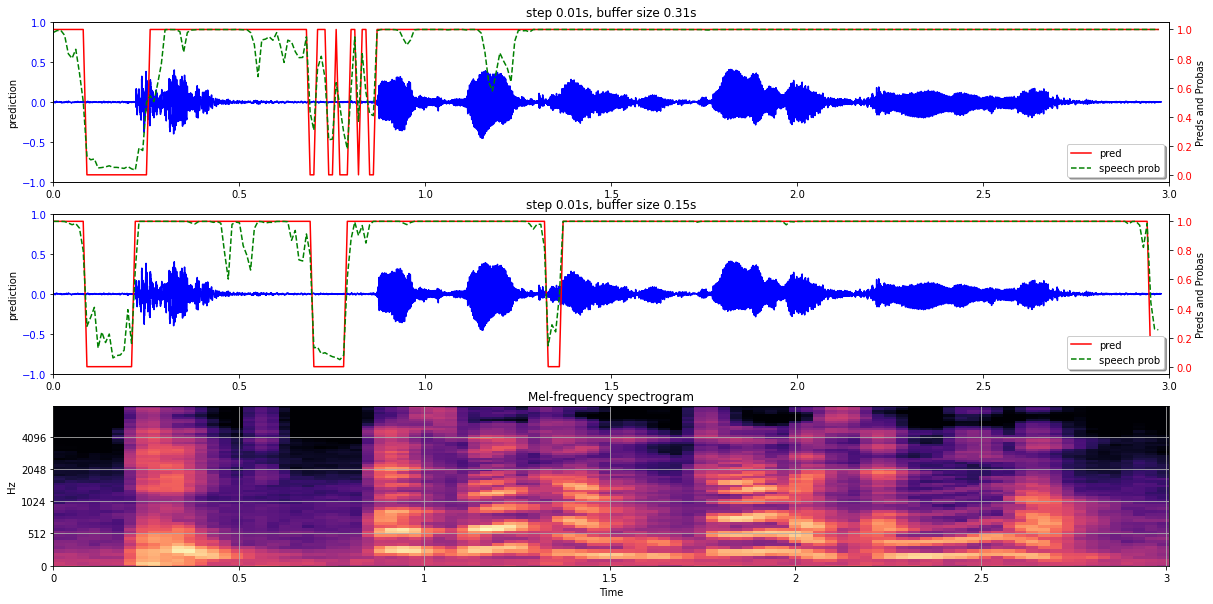

In [21]:
import librosa.display
plt.figure(figsize=[20,10])

num = len(results)
for i in range(num):
    len_pred = len(results[i][2]) 
    FRAME_LEN = results[i][0]
    ax1 = plt.subplot(num+1,1,i+1)

    ax1.plot(np.arange(audio.size) / sample_rate, audio, 'b')
    ax1.set_xlim([0, int(dur)+1]) 
    ax1.tick_params(axis='y', labelcolor= 'b')
    ax1.set_ylabel('Signal')
    ax1.set_ylim([-1,  1])

    ax2 = ax1.twinx()
    ax2.plot(np.arange(len_pred)/(1/results[i][0]), np.array(results[i][2])  , 'r', label='pred')
    ax2.plot(np.arange(len_pred)/(1/results[i][0]), np.array(results[i][4]) ,  'g--', label='speech prob')
    ax2.tick_params(axis='y', labelcolor='r')
    legend = ax2.legend(loc='lower right', shadow=True)
    ax1.set_ylabel('prediction')

    ax2.set_title(f'step {results[i][0]}s, buffer size {results[i][1]}s')
    ax2.set_ylabel('Preds and Probas')
    
    
ax = plt.subplot(num+1,1,i+2)
S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=64, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
ax.set_title('Mel-frequency spectrogram')
ax.grid()
plt.show()

## Online inference through microphone

In [22]:
STEP = 0.01 
WINDOW_SIZE = 0.31
CHANNELS = 1 
RATE = 16000
FRAME_LEN = STEP

CHUNK_SIZE = int(STEP * RATE)
asr = FrameASR(model_definition = {
                   'sample_rate': SAMPLE_RATE,
                   'AudioToMFCCPreprocessor': cfg.preprocessor.params,
                   'JasperEncoder': cfg.encoder.params,
                   'labels': cfg.labels
               },
               frame_len=FRAME_LEN, frame_overlap=(WINDOW_SIZE - FRAME_LEN) / 2, 
               offset=0)


In [23]:
asr.reset()

p = pa.PyAudio()
print('Available audio input devices:')
input_devices = []
for i in range(p.get_device_count()):
    dev = p.get_device_info_by_index(i)
    if dev.get('maxInputChannels'):
        input_devices.append(i)
        print(i, dev.get('name'))

if len(input_devices):
    dev_idx = -2
    while dev_idx not in input_devices:
        print('Please type input device ID:')
        dev_idx = int(input())

    empty_counter = 0

    def callback(in_data, frame_count, time_info, status):
        global empty_counter
        signal = np.frombuffer(in_data, dtype=np.int16)
        text = asr.transcribe(signal)
        if len(text):
            print(text,end='\n')
            empty_counter = asr.offset
        elif empty_counter > 0:
            empty_counter -= 1
            if empty_counter == 0:
                print(' ',end='\n')
        return (in_data, pa.paContinue)

    stream = p.open(format=pa.paInt16,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    input_device_index=dev_idx,
                    stream_callback=callback,
                    frames_per_buffer=CHUNK_SIZE)

    print('Listening...')

    stream.start_stream()
    
    # Interrupt kernel and then speak for a few more words to exit the pyaudio loop !
    try:
        while stream.is_active():
            time.sleep(0.1)
    finally:        
        stream.stop_stream()
        stream.close()
        p.terminate()

        print()
        print("PyAudio stopped")
    
else:
    print('ERROR: No audio input device found.')

Available audio input devices:
0 pulse
1 default
Please type input device ID:
1
Listening...
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684,

[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.23

[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.23

[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.23

[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.23

[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.23

[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.23

[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.2373303 -1.2358323]']
[0, 'background', 0.922238826751709, 0.07776112109422684, '[ 1.23

KeyboardInterrupt: 